#Lung Cancer Pre-Screening leveraged by deep learning and convolutional neural networks

###This script generates two target models for the use in lung cancer detection from computed tomography imaging. The source data set applied to this problem was gathered by Kaggle user Mohamed Hany and is pre split into a 70% training, 20% testing, 10% validation composition. Images have been pre-converted from their original DICOM formats to .png extensions, however it is unknown if the source files are DICOM-lossless or DICOM-lossy which may influence feature extraction in the models used.

## Model performance is validated using ROC-AUC (min-max averaged) and supported by a multi-class confusion matrix.




The train folder:


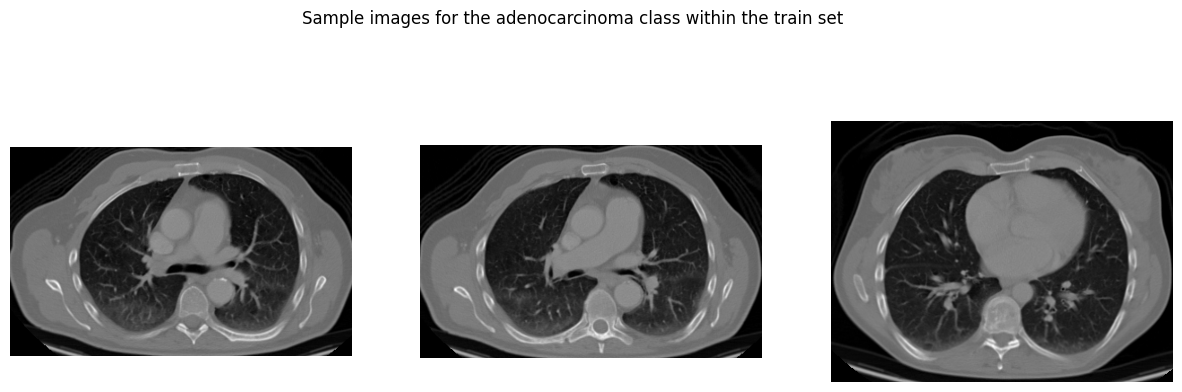

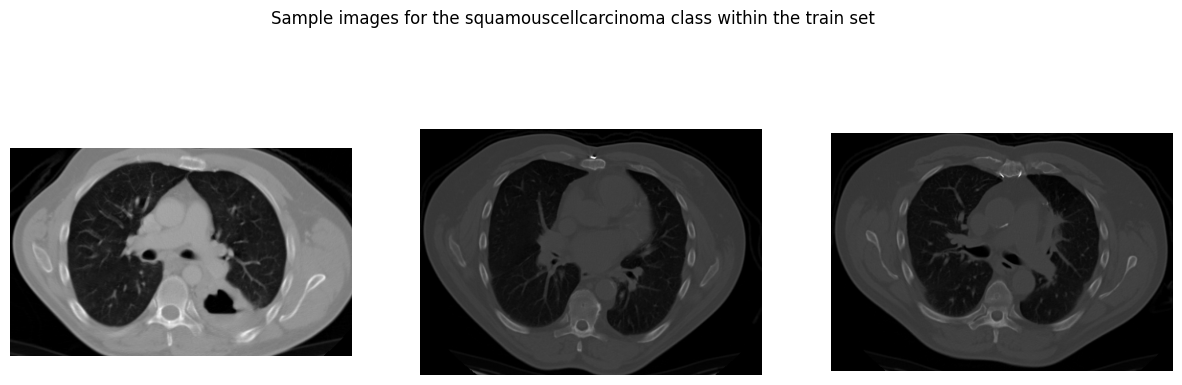

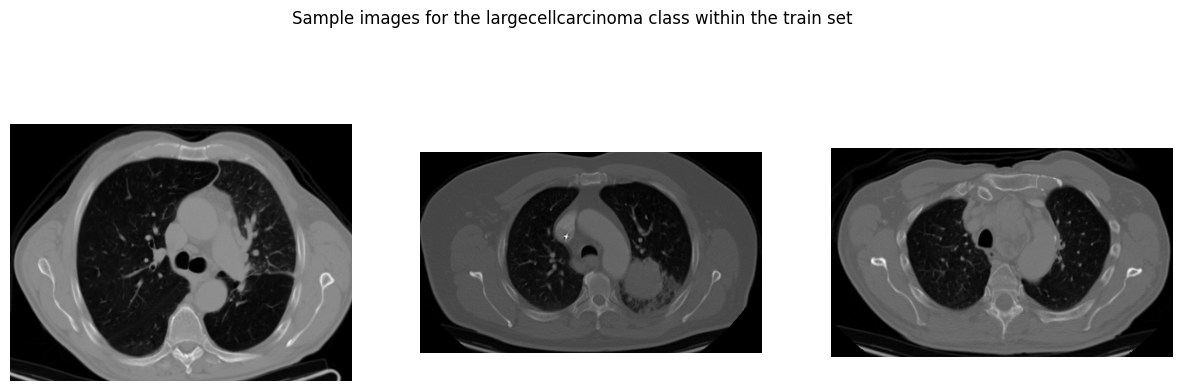

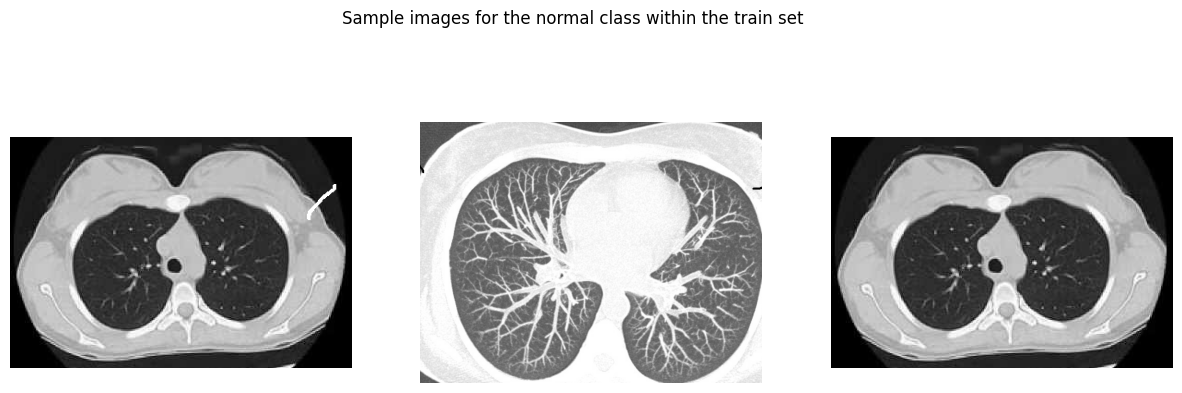

The valid folder:


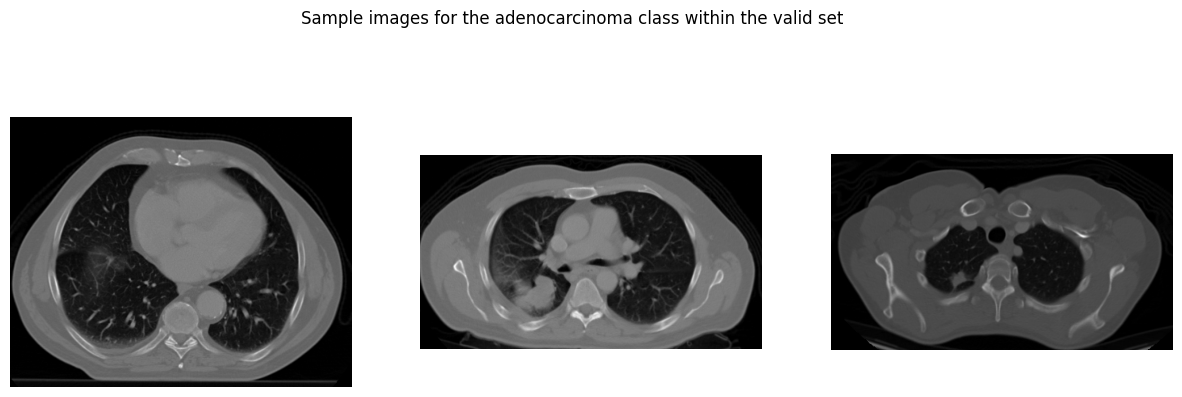

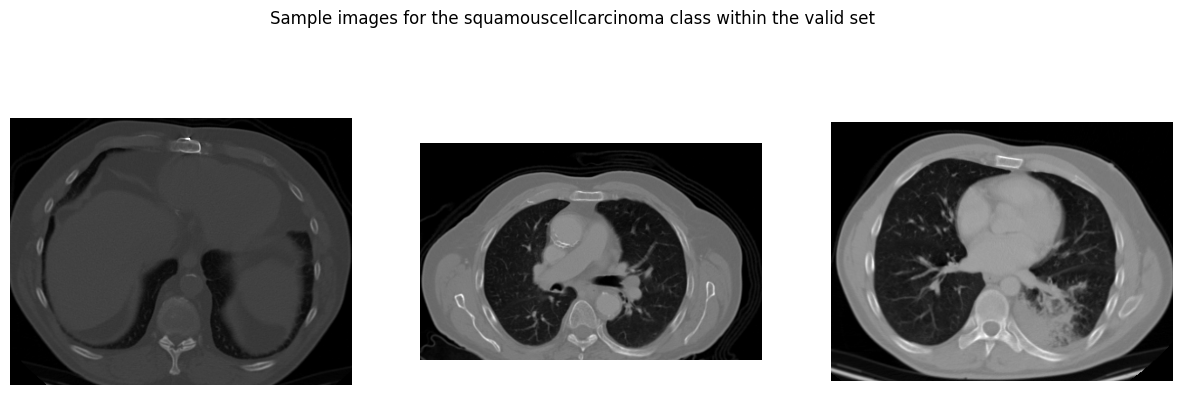

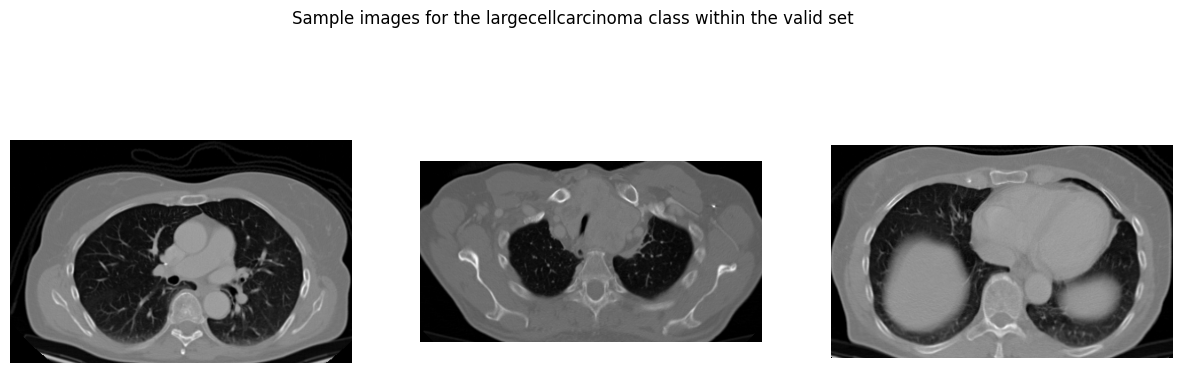

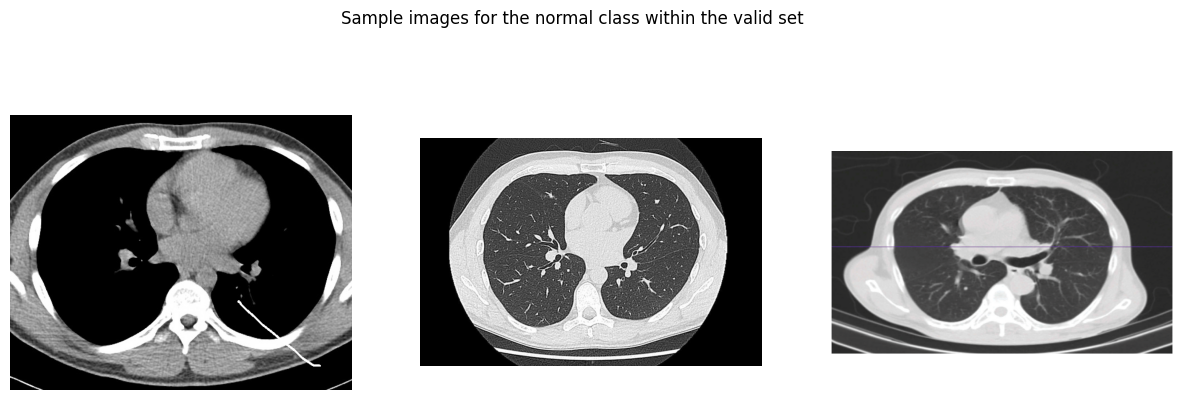

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define the main directory of the images
base_dir = '/content/drive/MyDrive/CT'

# Define the sub directories
sub_dirs = ['train', 'valid']
labels = [ 'adenocarcinoma', 'squamouscellcarcinoma', 'largecellcarcinoma', 'normal']

for sub in sub_dirs:
    print(f'The {sub} folder:')
    for label in labels:
        # Get the list of all files in directory
        folder = os.path.join(base_dir, sub, label)
        image_files = os.listdir(folder)

        #display the first 3 images in each folder
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Sample images for the {label} class within the {sub} set')

        for i, image_file in enumerate(image_files[:3]):
            # Read the image file
            image_path = os.path.join(folder, image_file)
            image = cv2.imread(image_path)

            # Convert the image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Display the image
            ax[i].imshow(image)
            ax[i].axis('off')

        plt.show()

#**Data Frame generation and descriptive statistics**


###The properties required for tabular data analysis are embedded within each image so metadata must be extracted in order to identify their attributes.


###Features like pixel size, image mode, file size and color space compositions can provide valuable information that can inform on decisions in the model building process.  


#####Note: Color channels for the images are split between RGB and RGBA. The inclusion of the alpha channel in these images may impact the shape of the image array during preprocessing. Color channels can be standardized and the alpha channel can be removed to eliminate this concern with Pillow's .convert() function.

In [ ]:
import pandas as pd
from PIL import Image
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
# Create an empty DataFrame
df = pd.DataFrame(columns=['Sub-directory', 'Label', 'Filename', 'File Size (KB)', 'Image Width', 'Image Height', 'Image Mode', 'Pixel Size', 'Avg Color'])

for sub in sub_dirs:
    for label in labels:
        # Get the list of all files in directory
        folder = os.path.join(base_dir, sub, label)
        image_files = os.listdir(folder)

        for image_file in image_files:
            # Read the image file
            image_path = os.path.join(folder, image_file)
            image = Image.open(image_path)

            # Get the file size in KB
            file_size = os.path.getsize(image_path) / 1024

            # Get the pixel size (assume 1 if not in metadata)
            pixel_size = image.info.get('dpi', (1, 1))

            # Get the average color for GREYSCALE images and make datatype int for visualization
            np_image = np.array(image)
            reshaped_image = np_image.reshape(-1, np_image.shape[-1])
            avg_color = tuple(reshaped_image.mean(axis=0).round().astype(int))







            # Append the info to the DataFrame
            data = pd.DataFrame({
                'Sub-directory': [sub],
                'Label': [label],
                'Filename': [image_file],
                'File Size (KB)': [file_size],
                'Image Width': [image.width],
                'Image Height': [image.height],
                'Image Mode': [image.mode],
                'Pixel Size': [pixel_size],
                'Avg Color': [avg_color]
            })
            df = pd.concat([df, data], ignore_index=True)

# Print the DataFrame
print(df)


    Sub-directory           Label              Filename  File Size (KB)  \
0           train  adenocarcinoma        000071 (3).png       80.293945   
1           train  adenocarcinoma        000084 (3).png       82.146484   
2           train  adenocarcinoma       000026 (10).png       75.385742   
3           train  adenocarcinoma       000080 (10).png       69.323242   
4           train  adenocarcinoma        000029 (4).png       87.251953   
..            ...             ...                   ...             ...   
680         valid          normal                 7.png      560.711914   
681         valid          normal  004007_01_01_519.png      122.365234   
682         valid          normal      8 - Copy (3).png      545.207031   
683         valid          normal          6 - Copy.png      256.574219   
684         valid          normal  003828_02_01_174.png      313.562500   

    Image Width Image Height Image Mode        Pixel Size          Avg Color  
0           382     

In [ ]:
#transposed stats by row
#print(df.transpose())

In [ ]:
#print column names for easy access
print(df.columns)

Index(['Sub-directory', 'Label', 'Filename', 'File Size (KB)', 'Image Width',
       'Image Height', 'Image Mode', 'Pixel Size', 'Avg Color'],
      dtype='object')


# Image height and width distributions

#### Exploration of the metadata shows the majority of image HxW within 250x300 px. This information can be useful to determine if individual image scaling is needed during preprocessing.

#### By visualizing the scatter of height and width by label it can be seen that each NSCLC class is clustered tightly within the same HxW range.

#### This can help inform on decisions related to the use of data augmentation parameters such as shear and crop transformations in order to create a more robust artificial data set.

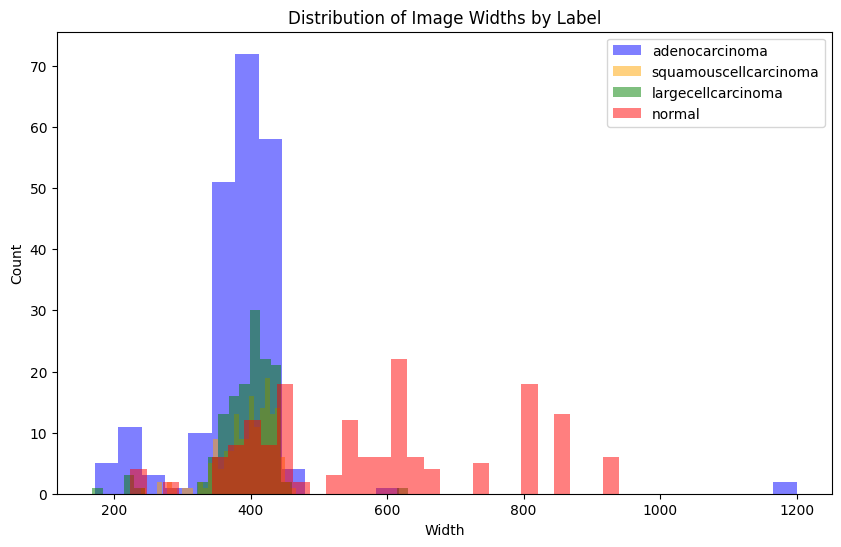

In [ ]:
plt.figure(figsize=(10, 6))
labels = df['Label'].unique()
colors = ['blue', 'orange', 'green', 'red']
# Adjust the colors based on the number of unique labels

for label, color in zip(labels, colors):
    label_data = df[df['Label'] == label]['Image Width']
    plt.hist(label_data, bins=30, alpha=0.5, color=color, label=label)

plt.title('Distribution of Image Widths by Label')
plt.xlabel('Width')
plt.ylabel('Count')
plt.legend()
plt.show()



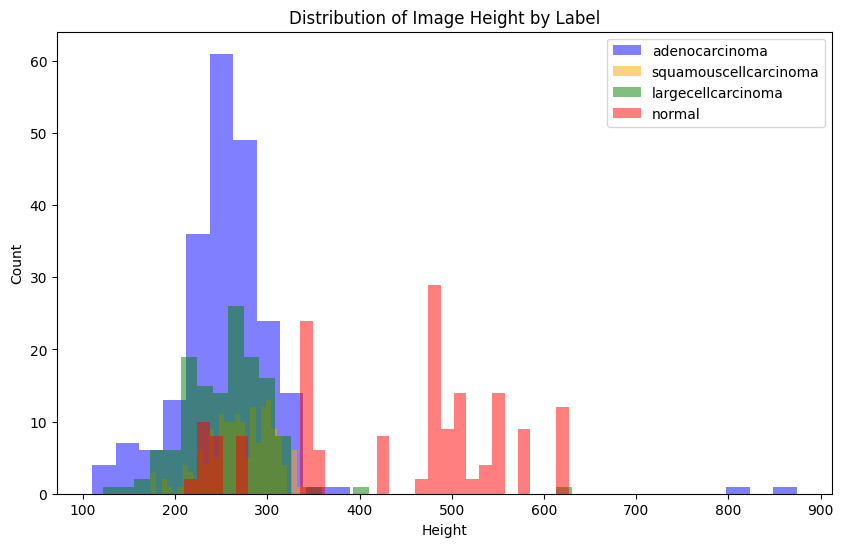

In [ ]:
plt.figure(figsize=(10, 6))
labels = df['Label'].unique()
colors = ['blue', 'orange', 'green', 'red']  # Adjust the colors based on the number of unique labels

for label, color in zip(labels, colors):
    label_data = df[df['Label'] == label]['Image Height']
    plt.hist(label_data, bins=30, alpha=0.5, color=color, label=label)

plt.title('Distribution of Image Height by Label')
plt.xlabel('Height')
plt.ylabel('Count')
plt.legend()
plt.show()

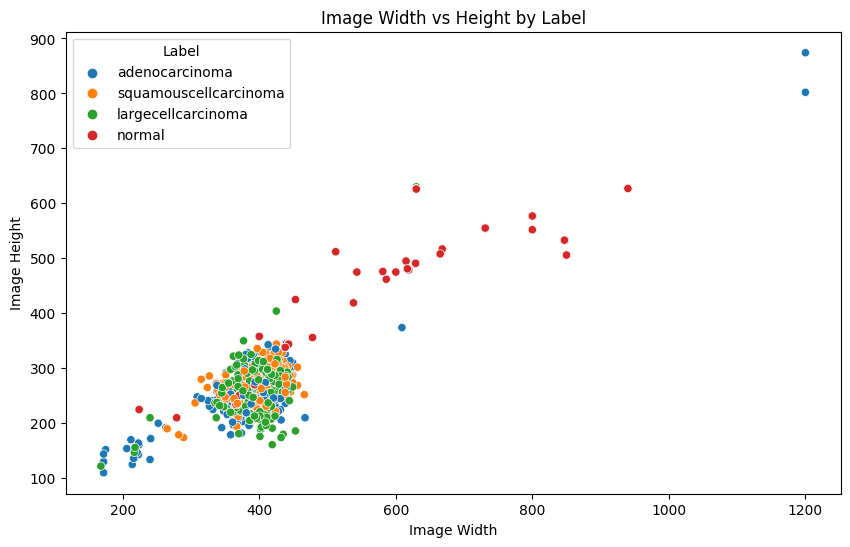

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Image Width', y='Image Height', hue='Label', data=df)
plt.title('Image Width vs Height by Label')
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.show()

#### In the problem being analyzed, file size is unlikely to be a significant factor in performance of the image classifier. The data set is relatively small and the image set can easily be stored using Google Drive on an unpaid plan.

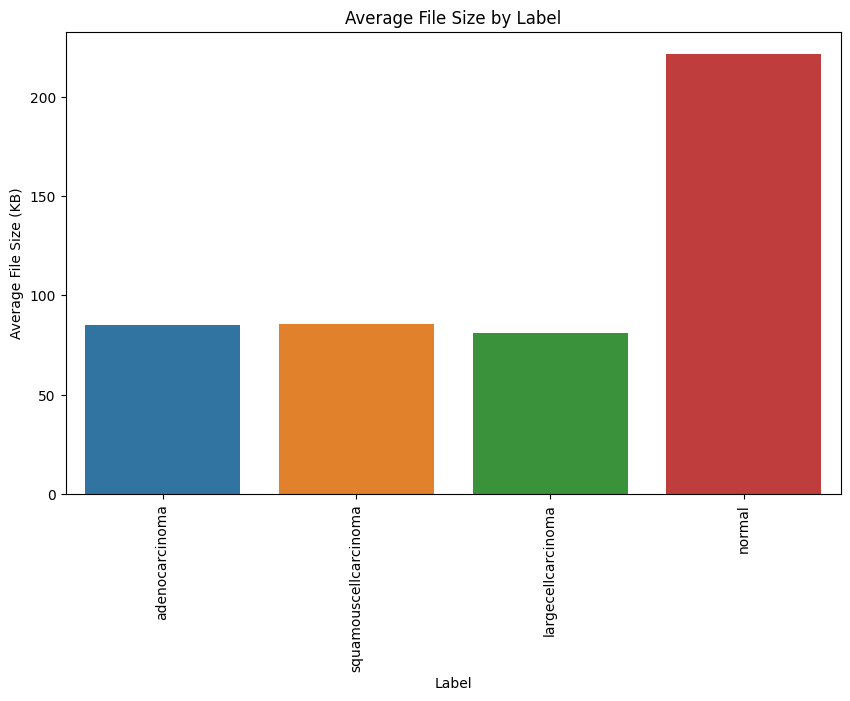

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Label', y='File Size (KB)', data=df, estimator=np.mean, errorbar=None)
plt.title('Average File Size by Label')
plt.xlabel('Label')
plt.ylabel('Average File Size (KB)')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility
plt.show()


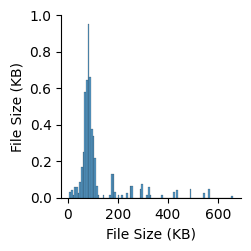

In [ ]:
sns.pairplot(df.select_dtypes(include=np.number))
plt.show()

### The distribution of image mode can inform on sensible model architecture choices. Some architectures may require a standardized image mode while others may allow for multiple image modes to be processed. In the case of the CT-Image dataset, only one image appears as L (Greyscale), and less than 50 appear with RGB color channels.

### The RGB and L channel images in question are visually indistinguishable from the RGBA majority class because modern computer monitors only support RGB output and the L mode images are converted to RGB when displayed.

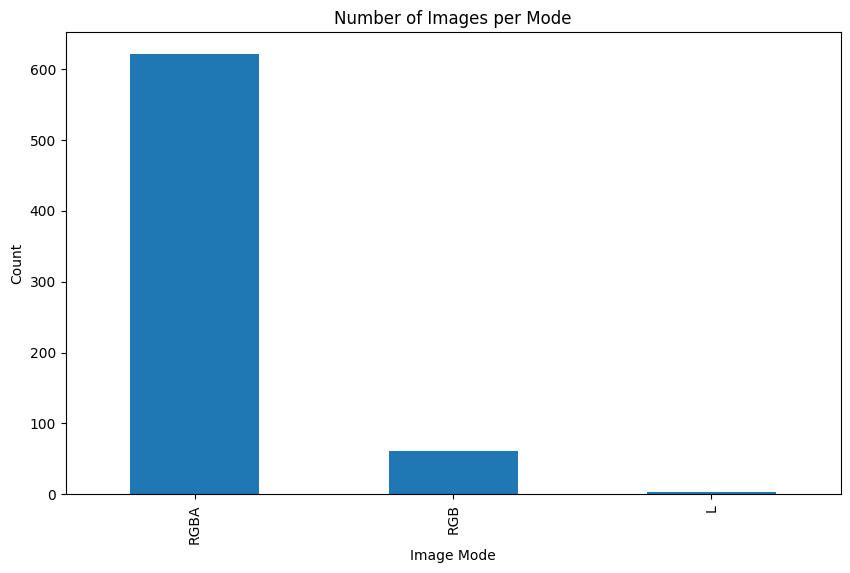

In [ ]:
plt.figure(figsize=(10, 6))
df['Image Mode'].value_counts().plot(kind='bar')
plt.title('Number of Images per Mode')
plt.xlabel('Image Mode')
plt.ylabel('Count')
plt.show()

#Filter average color components

### To analyze the color map of each image, each array is extracted into a dataframe.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out rows where 'Avg Color' is not a tuple or list
dfcolor = df[df['Avg Color'].apply(lambda x: isinstance(x, (tuple, list)))]

# Extract RGB components
dfcolor['Avg Red'] = dfcolor['Avg Color'].apply(lambda x: x[0] if len(x) >= 1 else np.nan)
dfcolor['Avg Green'] = dfcolor['Avg Color'].apply(lambda x: x[1] if len(x) >= 2 else np.nan)
dfcolor['Avg Blue'] = dfcolor['Avg Color'].apply(lambda x: x[2] if len(x) >= 3 else np.nan)


# Drop rows with missing color components
dfcolor.dropna(subset=['Avg Red', 'Avg Green', 'Avg Blue'], inplace=True)

# Create a figure with subplots
fig, axs = plt.subplots(3, figsize=(10, 6))

# Plot the histograms using Seaborn
sns.histplot(dfcolor['Avg Red'], bins=30, color='r', ax=axs[0])
sns.histplot(dfcolor['Avg Green'], bins=30, color='g', ax=axs[1])
sns.histplot(dfcolor['Avg Blue'], bins=30, color='b', ax=axs[2])

axs[0].set_title('Average Red Component')
axs[1].set_title('Average Green Component')
axs[2].set_title('Average Blue Component')

for ax in axs.flat:
    ax.set(xlabel='Color Intensity', ylabel='Count')

plt.tight_layout()
plt.show()















#Class distribution

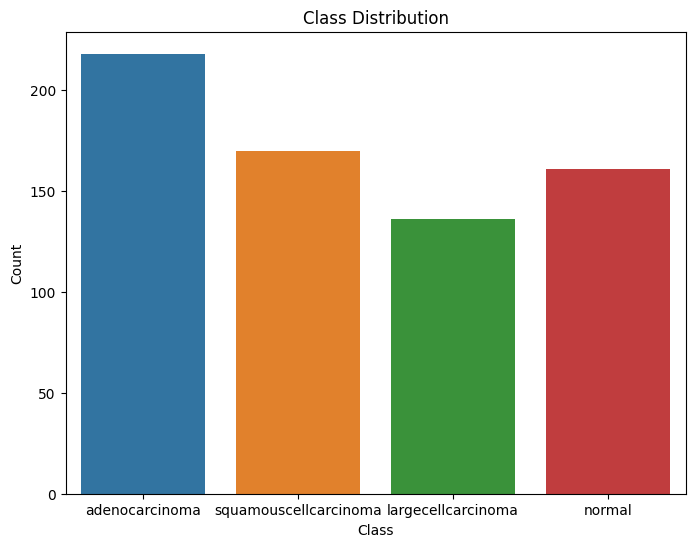

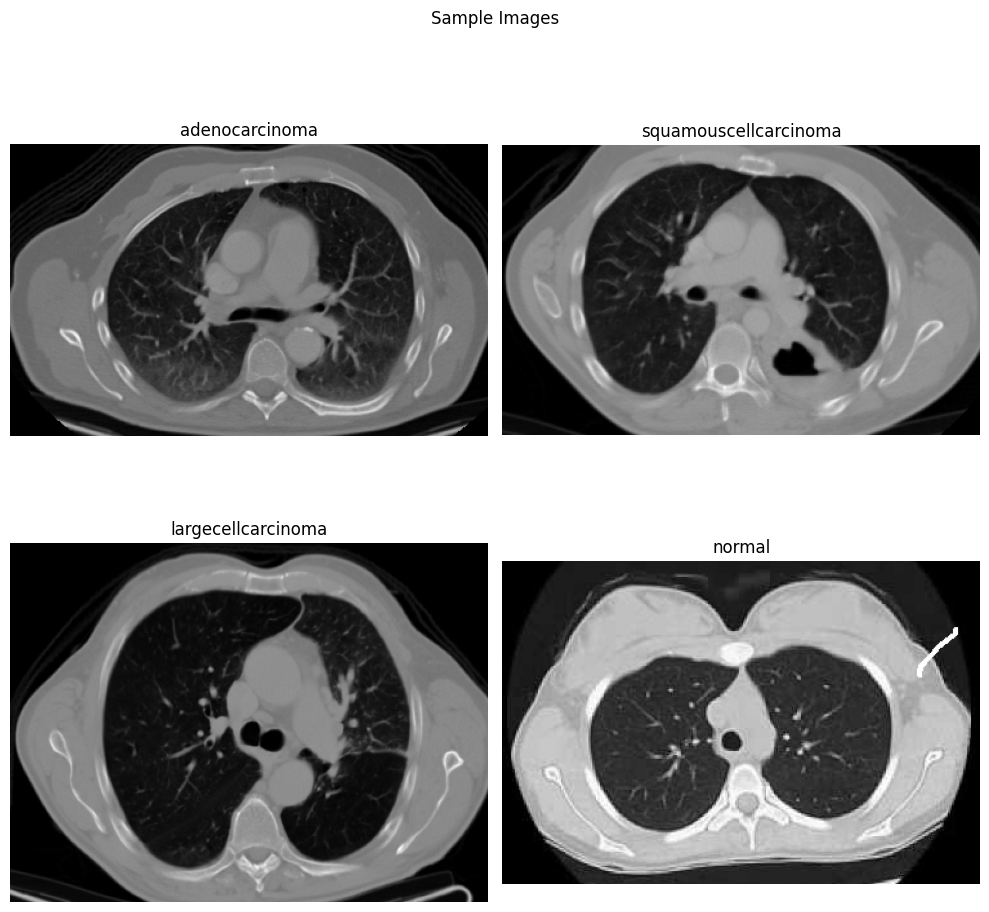

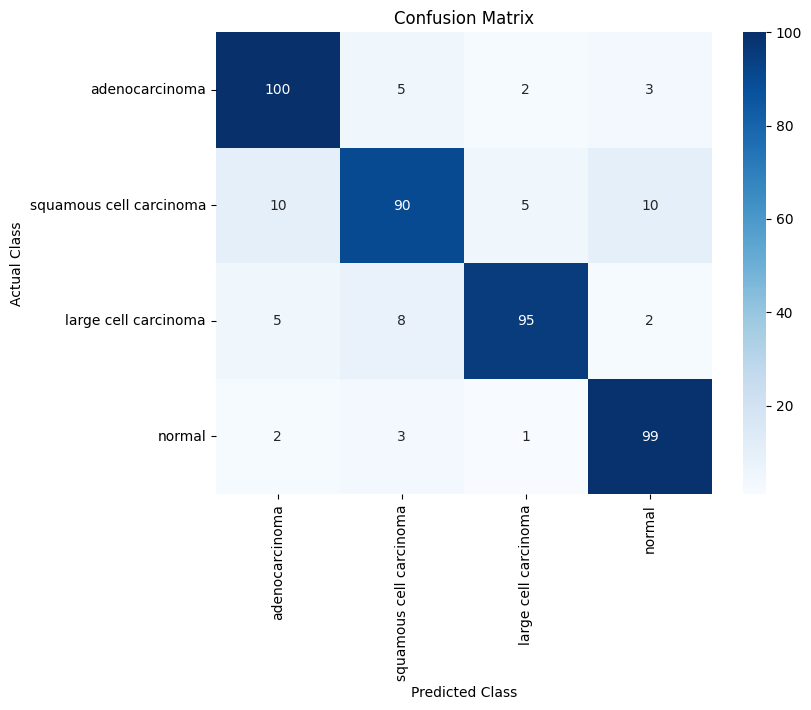

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Label')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Sample Images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, label in enumerate(labels):
    sample_image = df[df['Label'] == label].iloc[0]['Filename']
    image_path = os.path.join(base_dir, 'train', label, sample_image)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i // 2, i % 2].imshow(image)
    axs[i // 2, i % 2].set_title(label)
    axs[i // 2, i % 2].axis('off')
plt.suptitle('Sample Images')
plt.tight_layout()
plt.show()

# Confusion Matrix (Example)
confusion_matrix = [[100, 5, 2, 3],
                    [10, 90, 5, 10],
                    [5, 8, 95, 2],
                    [2, 3, 1, 99]]
class_labels = ['adenocarcinoma', 'squamous cell carcinoma', 'large cell carcinoma', 'normal']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()




#View the generated MetaData dataframe.

In [ ]:
df

Sub-directory           Label              Filename  File Size (KB)  \
0           train  adenocarcinoma        000071 (3).png       80.293945   
1           train  adenocarcinoma        000084 (3).png       82.146484   
2           train  adenocarcinoma       000026 (10).png       75.385742   
3           train  adenocarcinoma       000080 (10).png       69.323242   
4           train  adenocarcinoma        000029 (4).png       87.251953   
..            ...             ...                   ...             ...   
680         valid          normal                 7.png      560.711914   
681         valid          normal  004007_01_01_519.png      122.365234   
682         valid          normal      8 - Copy (3).png      545.207031   
683         valid          normal          6 - Copy.png      256.574219   
684         valid          normal  003828_02_01_174.png      313.562500   

    Image Width Image Height Image Mode        Pixel Size          Avg Color  
0           382          234       RGBA  (96.012, 96.012)  (78, 78, 78, 255)  
1           381          237       RGBA  (96.012, 96.012)  (78, 78, 78, 255)  
2           338          258       RGBA  (96.012, 96.012)  (73, 73, 73, 255)  
3           354          230       RGBA  (96.012, 96.012)  (67, 67, 67, 255)  
4           372          273       RGBA  (96.012, 96.012)  (86, 86, 86, 255)  
..          ...          ...        ...               ...                ...  
680         940          627        RGB            (1, 1)    (100, 100, 100)  
681         512          512        RGB            (1, 1)       (38, 39, 38)  
682         800          577        RGB            (1, 1)    (116, 116, 116)  
683         581          476       RGBA  (96.012, 96.012)  (85, 85, 85, 255)  
684         512          512        RGB            (1, 1)    (127, 127, 127)  

[685 rows x 9 columns]

In [ ]:
df.nunique()

Sub-directory       2
Label               4
Filename          616
File Size (KB)    577
Image Width       167
Image Height      193
Image Mode          3
Pixel Size          4
Avg Color         122
dtype: int64

#Assign paths to three sample images for each image mode.

In [ ]:
L_path = [
    '/content/drive/MyDrive/CT/train/largecellcarcinoma/l5.png',
    '/content/drive/MyDrive/CT/train/normal/2.png',
    '/content/drive/MyDrive/CT/train/normal/2 - Copy (3).png',

]
RGB_path = [
    '/content/drive/MyDrive/CT/train/largecellcarcinoma/l4.png',
    '/content/drive/MyDrive/CT/train/normal/5.png',
    '/content/drive/MyDrive/CT/train/normal/3.png',

]
RGBA_path = [
    '/content/drive/MyDrive/CT/train/largecellcarcinoma/000062.png',
    '/content/drive/MyDrive/CT/train/normal/10.png',
    '/content/drive/MyDrive/CT/train/normal/11.png',

]










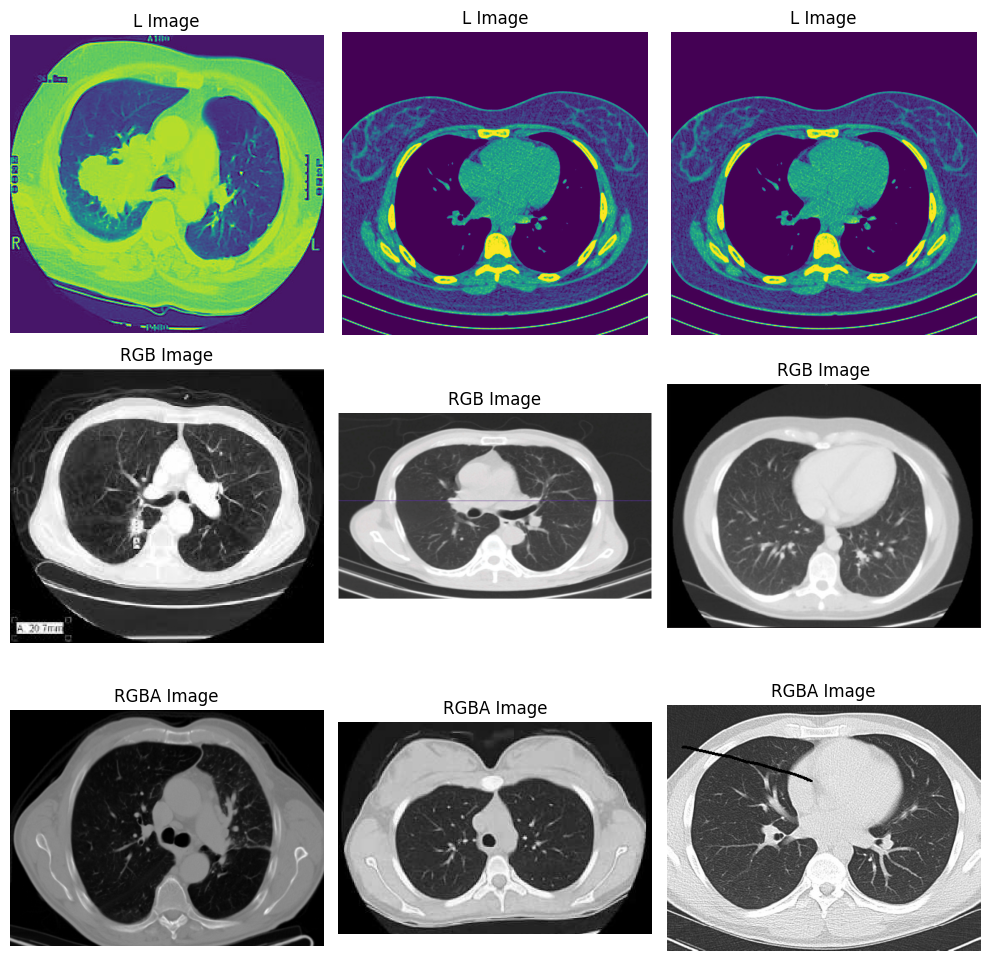

In [ ]:
import matplotlib.image as mpimg
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Loop through the L images and display them in subplots
for i, path in enumerate(L_path):
    try:
        # Load the image
        image = mpimg.imread(path)

        # Calculate the subplot position
        row = i // 3
        col = i % 3

        # Display the image in the corresponding subplot
        axs[row, col].imshow(image)
        axs[row, col].axis('off')
        axs[row, col].set_title('L Image')

    except FileNotFoundError:
        print(f"File not found: {path}")

# Loop through the RGB images and display them in subplots
for i, path in enumerate(RGB_path):
    try:
        # Load the image
        image = mpimg.imread(path)

        # Calculate the subplot position
        row = (i + 3) // 3
        col = (i + 3) % 3

        # Display the image in the corresponding subplot
        axs[row, col].imshow(image)
        axs[row, col].axis('off')
        axs[row, col].set_title('RGB Image')

    except FileNotFoundError:
        print(f"File not found: {path}")

# Loop through the RGBA images and display them in subplots
for i, path in enumerate(RGBA_path):
    try:
        # Load the image
        image = mpimg.imread(path)

        # Calculate the subplot position
        row = (i + 6) // 3
        col = (i + 6) % 3

        # Display the image in the corresponding subplot
        axs[row, col].imshow(image)
        axs[row, col].axis('off')
        axs[row, col].set_title('RGBA Image')

    except FileNotFoundError:
        print(f"File not found: {path}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



#Adjusting the 'Pixel Size' label to generate mean values for R,G,B,A components within the arrays.

In [ ]:
#Run once and then revert to comment
#df['Pixel Size'] = df['Pixel Size'].apply(lambda x: float(x[0]))

In [ ]:
df['File Size (KB)'] = pd.to_numeric(df['File Size (KB)'])


In [ ]:
avgcolormeanred  = df['Avg Color'].apply(lambda x: x[0])
avgcolormeangreen = df['Avg Color'].apply(lambda x: x[1])
avgcolormeanblue = df['Avg Color'].apply(lambda x: x[2])
avgcolormeanalpha = df['Avg Color'].apply(lambda x: x[3] if len(x) == 4 else None)


#Descriptive statistics

In [ ]:


imagemodecount = df['Image Mode'].value_counts()


filesizemedian = df['File Size (KB)'].median()
filesizemean = df['File Size (KB)'].mean()
filesizestd = np.std(df['File Size (KB)'])
imageheightmedian = df['Image Height'].median()
imageheightmean = np.mean(df['Image Height'])
imageheightstd = np.std(df['Image Height'])
imagewidthmedian = df['Image Width'].median()
imagewidthmean = df['Image Width'].mean()
imagewidthstd = np.std(df['Image Width'])
pixelsizemean = df['Pixel Size'].mean()
pixelsizestd = np.std(df['Pixel Size'])


print(f"Image Mode Count:\n{imagemodecount}\n")
print(f"Avg Color Red: {avgcolormeanred}\n Avg Color Blue: {avgcolormeanblue}\n Avg Color Green: {avgcolormeangreen}\n Avg Color Alpha: {avgcolormeanalpha}\n")
print(f"File Size Median: {filesizemedian}\n")
print(f"File Size Mean: {filesizemean}\n")
print(f"File Size Standard Dev: {filesizestd}\n")
print(f"Image Height Median: {imageheightmedian}\n")
print(f"Image Height Mean: {imageheightmean}\n")
print(f"Image Height Standard Dev: {imageheightstd}\n")
print(f"Image Width Median: {imagewidthmedian}\n")
print(f"Image Width Mean: {imagewidthmean}\n")
print(f"Image Width Standard Dev: {imagewidthstd}\n")
print(f"Pixel Size Mean: {pixelsizemean}\n")
print(f"Pixel Size Standard Dev: {pixelsizestd}\n")




Image Mode Count:
RGBA    621
RGB      61
L         3
Name: Image Mode, dtype: int64

Avg Color Red: 0       78
1       78
2       73
3       67
4       86
      ... 
680    100
681     38
682    116
683     85
684    127
Name: Avg Color, Length: 685, dtype: int64
 Avg Color Blue: 0       78
1       78
2       73
3       67
4       86
      ... 
680    100
681     38
682    116
683     85
684    127
Name: Avg Color, Length: 685, dtype: int64
 Avg Color Green: 0       78
1       78
2       73
3       67
4       86
      ... 
680    100
681     39
682    116
683     85
684    127
Name: Avg Color, Length: 685, dtype: int64
 Avg Color Alpha: 0      255.0
1      255.0
2      255.0
3      255.0
4      255.0
       ...  
680      NaN
681      NaN
682      NaN
683    255.0
684      NaN
Name: Avg Color, Length: 685, dtype: float64

File Size Median: 85.34765625

File Size Mean: 116.43222941377738

File Size Standard Dev: 96.10441106641383

Image Height Median: 271.0

Image Height Mean: 302.9124

# Model preprocessing

In [ ]:
train = '/content/drive/MyDrive/CT/train'
test = '/content/drive/MyDrive/CT/test'
valid = '/content/drive/MyDrive/CT/valid'






In [ ]:
!pip install tensorflow


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten,Dropout,BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.utils import plot_model
from IPython.display import Image

#Colab may create .checkpoint files within the data set which need to be removed when parsing files for image data generator.

##ONLY expand and use this code block if ImageDataGenerator outputs a class composition less than or greater than 4 in the train, test or valid folders

In [ ]:
#This code block is meant to fix issues with ImageDataGenerator having an output of 5 labels in the next code block
#Colab generates checkpoint files and adds them to the folder. ImageDataGenerator treats these as a new label so they must be removed.
import os
import shutil
#Parse the folders to determine if an ipynb checkpoint exists
print("Parsing for hidden directories \n\n")
print("train folder directories:\n", os.listdir("/content/drive/MyDrive/CT/train"))
print("test folder directories:\n", os.listdir("/content/drive/MyDrive/CT/test"))
print("valid folder directories:\n", os.listdir("/content/drive/MyDrive/CT/valid"))
#Delete .ipynb checkpoint files generated from previous code.
#If no file is found in a directory use # to comment out the corresponding code below

#remove checkpoint from train folder
shutil.rmtree("/content/drive/MyDrive/CT/train/.ipynb_checkpoints")
#remove checkpoint from test folder
shutil.rmtree("/content/drive/MyDrive/CT/test/.ipynb_checkpoints")
#remove checkpoint from validation folder
shutil.rmtree("/content/drive/MyDrive/CT/valid/.ipynb_checkpoints")


#Running this script with ideal conditions should produce the error:
#FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CT/train/.ipynb_checkpoints'


#Set image path and load image samples

In [ ]:
image_paths = ['/content/drive/MyDrive/CT/train/adenocarcinoma',
'/content/drive/MyDrive/CT/train/largecellcarcinoma',
'/content/drive/MyDrive/CT/train/normal',
'/content/drive/MyDrive/CT/train/squamouscellcarcinoma']

def load_images(image_paths = image_paths, n=36):
    # Load the images from disk.
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.imread(image_paths[i]+'/'+path) for path in os.listdir(image_paths[i])[:int(n/4)]]
        images.append(images_)
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample

<ipython-input-6-b77d6821150d>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.asarray(images)


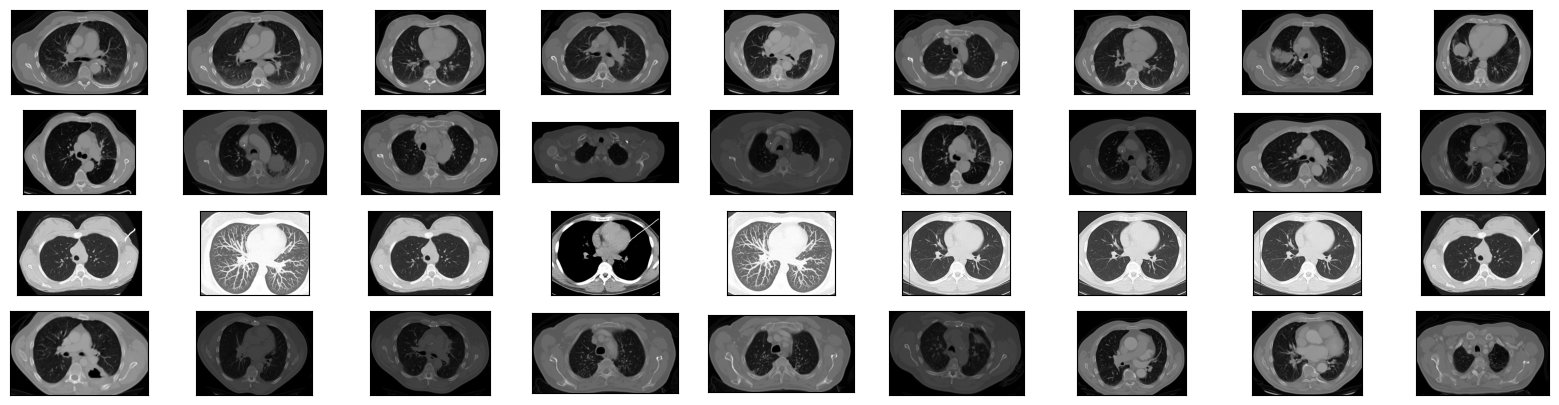

In [ ]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

#Check to confirm the images are writeable before image augmentation

In [ ]:
#Checking if the image is immutable. Writeable images will generate True and are able to be augmented.
from PIL import Image
iswriteable = np.array(Image.open('/content/drive/MyDrive/CT/train/adenocarcinoma/000022.png'))
print(iswriteable.flags.writeable)

True


#pip install tensorflow and import the libraries to be used

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
#Assign parameters to ImageDataGenerator and assign it to a variable for each
#corresponding folder, train, test and valid.
#the integrated preprocess_input function is used to normalized images in respect to color format of images in the imagenet dataset. This does not change scaling of images
#which was completed in an earlier step.

#attempt input shape (271,407,3) based on the mean value of height and width

INPUT_SHAPE = (320,320,3)
NUM_CLASSES=4
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(320,320),
    batch_size=32,
    class_mode='categorical',

)


test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(320,320),
    batch_size=32,
    class_mode='categorical',
)
validation_generator = val_datagen.flow_from_directory(
    valid,
    target_size=(320,320),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


#Modifying the base ResNet50 Model Architecture

In [ ]:

base_model = ResNet50(include_top=False,pooling='av',weights='imagenet',input_shape=(INPUT_SHAPE))
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,activation='softmax'))
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 batch_normalization (BatchN  (None, 204800)           819200    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               52429056  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 10

#Summarized visualization of the ResNet50 model

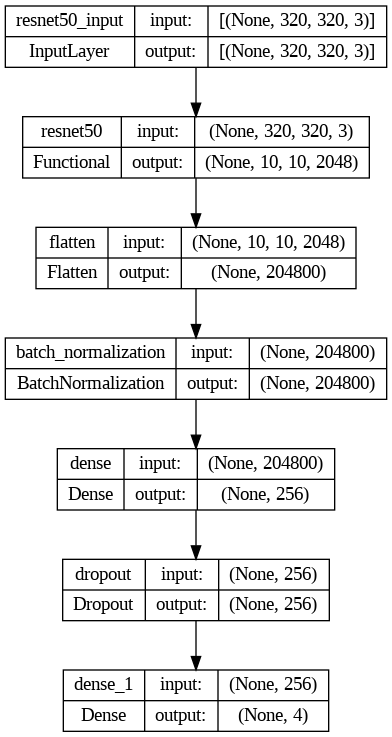

In [ ]:
#Provide a visualization of the  model
plot_model(model,to_file="resnet50.png",show_shapes=True,show_layer_names=True)
Image(filename="resnet50.png")

#Verbose ResNet50 model

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

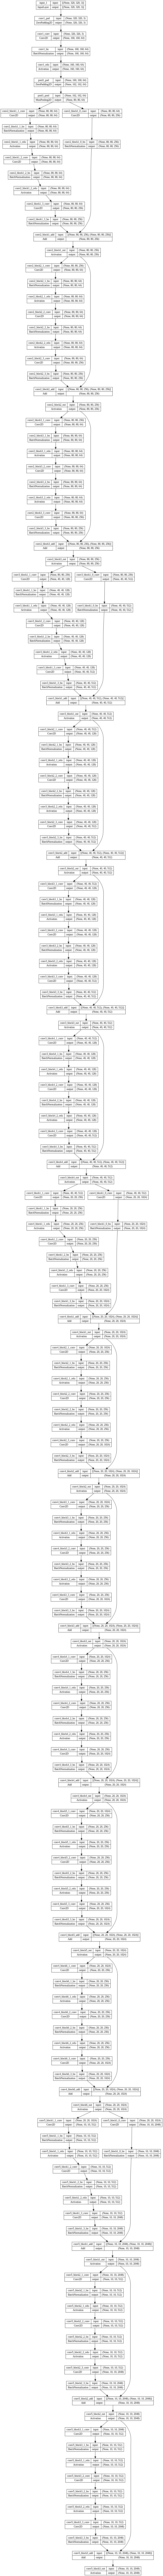

In [ ]:
#Provide a visualization of the base model
plot_model(base_model,to_file="resnet50.png",show_shapes=True,show_layer_names=True)
Image(filename="resnet50.png")


## This model utilizes the ADAM optimizer with categorical crossentropy loss scoring(Due to the problem being one of classification) and is used with an accuracy metric. The model may begin to converge ahead of the set parameter of 100 epochs. To prevent model degredation a function for stopping the model early has been implemented where patience for stopping the model can be set based on a prespecified threshold.

##Checkpoints are generated in the .h5 file which can be used as a pretrained model that can be either trained further or analyzed. It is recommended not to train the model further on the dataset used during training to prevent over-generalized learning.

In [ ]:
#Define Adam as the optimizer to use. Note: if new parameters are added, some may require using the ADAM legacy package
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)
#Set loss function and metrics to be used, generate a checkpoint file and assign it to a file path
#checkpoints are saved only if metrics rank higher than previous checkpoints
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/CTScanResNet50.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
#set a parameter to initiate early termination of the model within a set patience threshold
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)
#Assign the model history to a variable
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.8974 - accuracy: 0.3785
Epoch 1: val_loss improved from inf to 2.25012, saving model to /content/drive/MyDrive/CTScanResNet50.h5
20/20 [==============================] - 42s 1s/step - loss: 1.8974 - accuracy: 0.3785 - val_loss: 2.2501 - val_accuracy: 0.4167
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.4345 - accuracy: 0.5334
Epoch 2: val_loss improved from 2.25012 to 1.66805, saving model to /content/drive/MyDrive/CTScanResNet50.h5
20/20 [==============================] - 21s 1s/step - loss: 1.4345 - accuracy: 0.5334 - val_loss: 1.6680 - val_accuracy: 0.4444
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.2951 - accuracy: 0.5546
Epoch 3: val_loss improved from 1.66805 to 1.38239, saving model to /content/drive/MyDrive/CTScanResNet50.h5
20/20 [==============================] - 22s 1s/step - loss: 1.2951 - accuracy: 0.5546 - val_loss: 1.3824 - val_accuracy: 0.5417
Epoch

In [ ]:
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:  # if the layer has weights
        print(f"Layer {i} ({layer.name}) has weights with shape {weights[0].shape}")

In [ ]:
from tensorflow.keras.utils import plot_model

# assuming `model` is your model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
!pip install pydot graphviz

In [ ]:
#assign final loss and accuracy metrics to a variable
result = model.evaluate(test_generator)

10/10 [==============================] - 133s 15s/step - loss: 0.4730 - accuracy: 0.8222


In [ ]:
#view output for the loss/accuracy array
result

[0.6158958077430725, 0.8095238208770752]

#Visualizing accuracy and loss for ResNet50 custom arcitecture.
##Note: Restart the runtime after running each model.

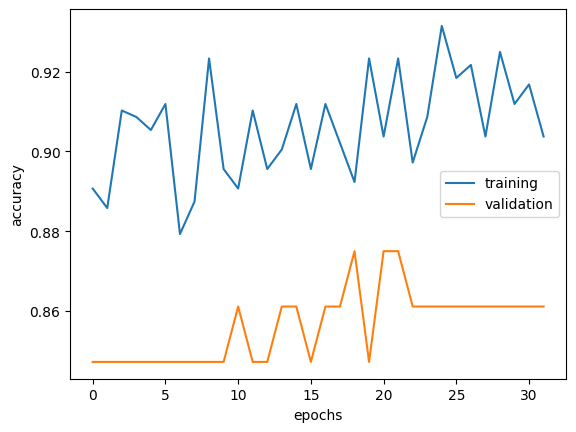

In [ ]:
#reimport matplotlib if starting without running visualization codeblocks
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label = 'training',)
plt.plot(history.history['val_accuracy'], label = 'validation')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()



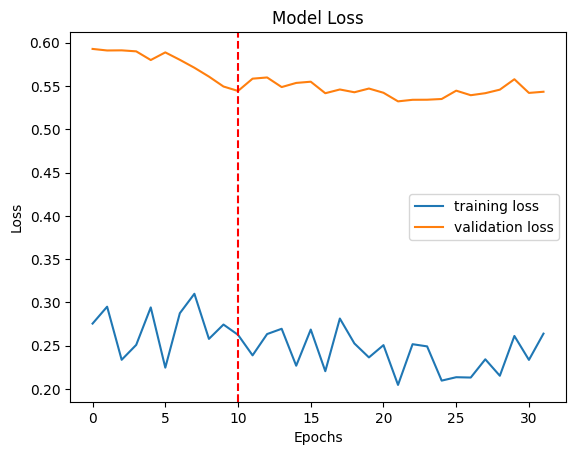

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.axvline(x=10, color='r', linestyle='--')  # assuming you want to mark the 11th epoch
plt.legend(loc='right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

#VGG16 ADAM optimized

##Note: The skimage library will sometimes throw dependency issues when importing gray2rgb depending on the version of skimage that is currently running in your environment. A restart of the runtime may be required if scikit-image is pip installed to be able to import skimage.color

In [ ]:
!pip install -U scikit-image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from skimage import io
from skimage.color import gray2rgb
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
#from typeguard import typechecked
from typing import Optional

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 35.6 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.1
    Uninstalling imageio-2.25.1:
      Successfully uninstalled imageio-2.25.1
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## VGG16 data ingestion

###VGG16 accepts an input shape of 224x224 px images consisting of RGB color channels. Images within the data set are mostly split between RGB and RGBA with one greyscale (L) color space image. The preprocess_input functionwill rectify this by automatically converting images to the appropriate color space.

###For each data generator the inputs are augmented to expand the variety of data available by rotating some images by 10 degrees, shifting image height and width by a factor of 0.2, image shearing, zoom, and flipping the image on the horizontal axis. In some cases augmentation using image zoom can result in poor performance and can be turned off by removal of zoom_range = 0.2 or commenting out that line in the code block.

###Batch sizes are set to 32 and can be changed depending on the capabilities of your runtime but must be a multiple of 32 (ie. 64, 128, 256, etc.). Larger batch sizes can promote better generalization across the data but can also result in crashes if not enough memory is available. If setting to a higher batch size change the runtime to accept a higher amount of ram utilization.

In [ ]:
input_shape = (224,224,3)
num_class = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.



#VGG 16 model
### The VGG16 model uses similar parameters to ResNet50. It was found that the default ADAM optimizer did not perform highly so the option of using RMSprop is added.



In [ ]:
#Use imagenet weights and freeze imagenet layers
modelVGG16 = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in modelVGG16.layers:
    layer.trainable = False

In [ ]:
#Set model parameters and define the MaxPooling2D layer size.
model = Sequential([
    modelVGG16,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])

#Output a model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4

In [ ]:

#Choose one of two optimizers with the same learning rate
adm_opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
rms_opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = rms_opt,
             metrics = ['accuracy'])



In [ ]:
#Defining a Checkpoint
checkpoint = ModelCheckpoint(filepath = 'C_CT_S.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

#Defining a Early Stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

#Defining LR Reducing rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

#Putting the call backs in a callback list
callbacks = [earlystop, reduce_lr]

In [ ]:
#Epochs were cut in half due to previous runs on ADAM optimization. A history variable is created and test loss and
#accuracy scores are generated
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

#Generate a multi-label classification report

In [ ]:

#print a classification report using the test generator
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)



10/10 [==============================] - 2s 212ms/step
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       120
           1       0.80      0.92      0.85        51
           2       1.00      0.98      0.99        54
           3       0.89      0.92      0.91        90

    accuracy                           0.91       315
   macro avg       0.91      0.92      0.91       315
weighted avg       0.91      0.91      0.91       315



#Multi class ROC curve

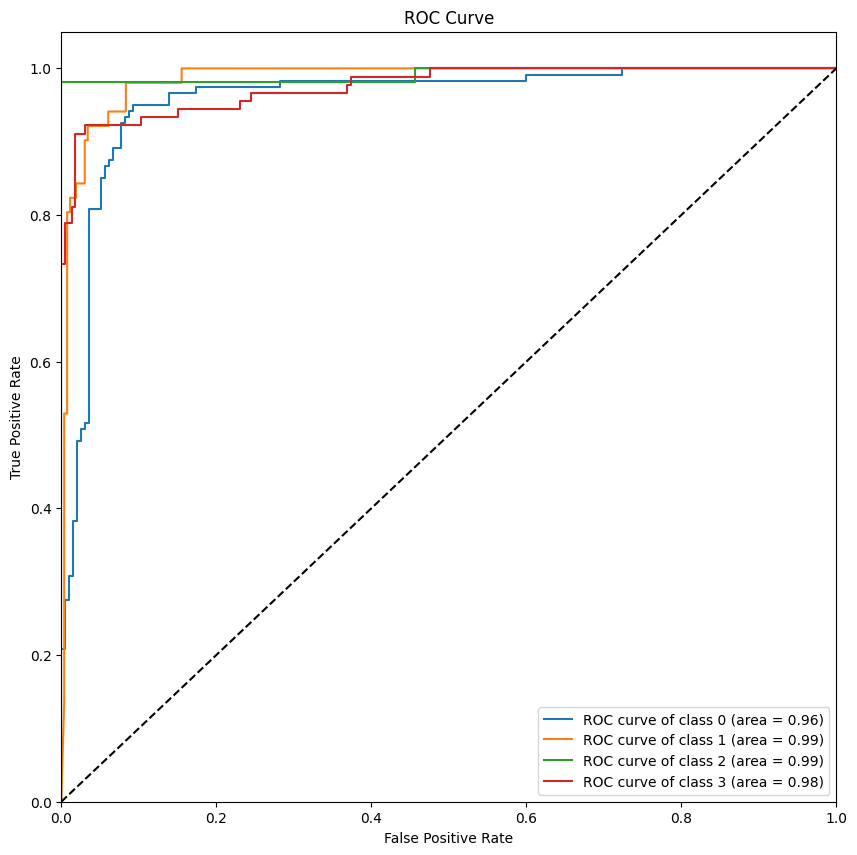

In [ ]:
#taken from the scikit learn documentation
#use matplotlib to visualize the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
#create a dictionary for each variable
fpr = dict()
tpr = dict()
roc_auc = dict()
#append iterated values to the dictionary
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

#change plot size
plt.figure(figsize=(10, 10))
#iterate over values and plot
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Binarize the output
lb = LabelBinarizer()
lb.fit(true_labels)
binarized_true_labels = lb.transform(true_labels)

roc_auc = roc_auc_score(binarized_true_labels, predicted_probabilities, multi_class='ovr')
print("ROC AUC: ", roc_auc)


ROC AUC:  0.9777734662363071


#micro/macro averaged ROC

<ipython-input-22-8e2ce2ea205a>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


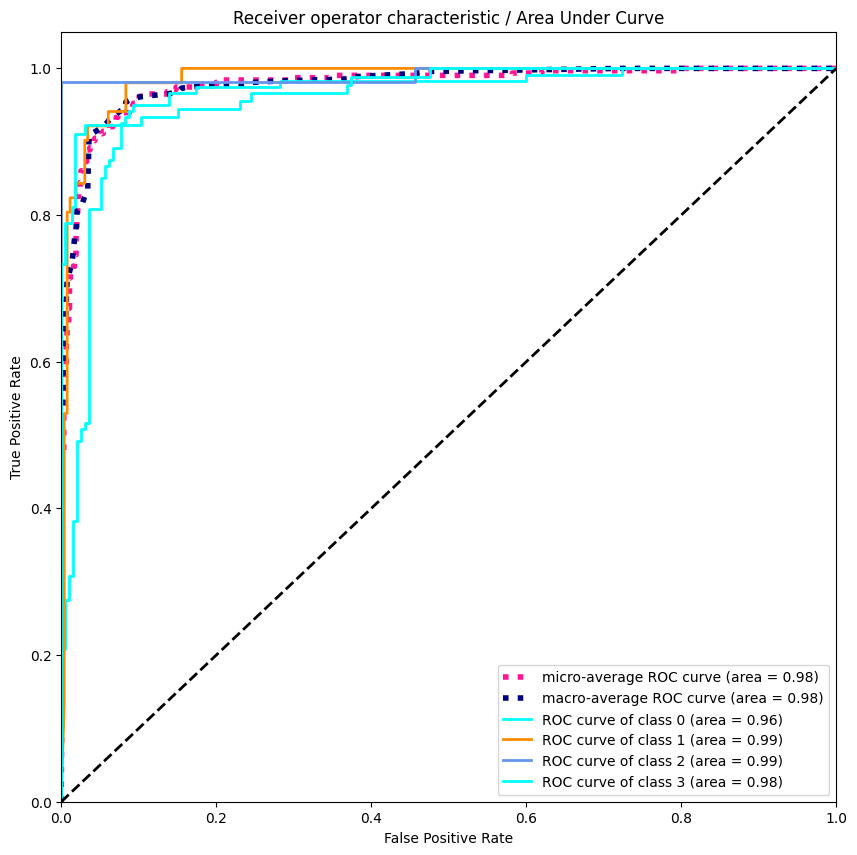

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

n_classes = num_classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the output
lb = LabelBinarizer()
lb.fit(true_labels)
binarized_true_labels = lb.transform(true_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_true_labels[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binarized_true_labels.ravel(), predicted_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operator characteristic / Area Under Curve')
plt.legend(loc="lower right")
plt.show()


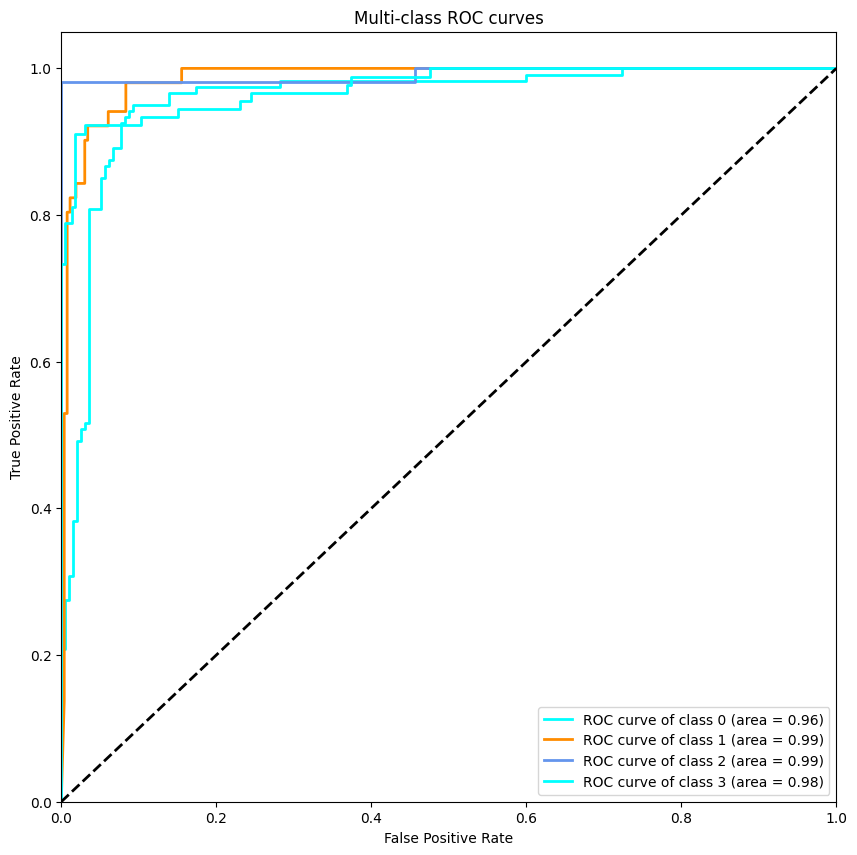

In [ ]:
plt.figure(figsize=(10, 10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()

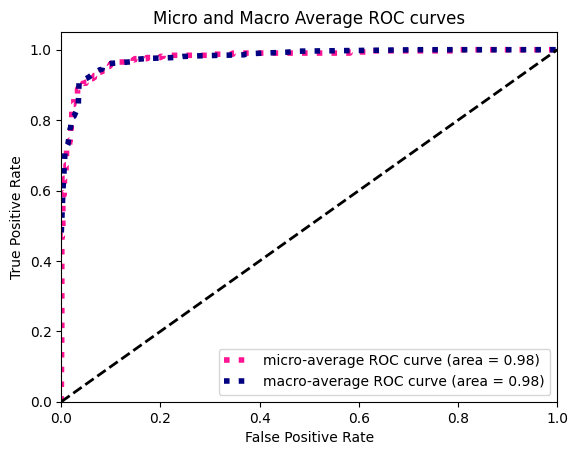

In [ ]:
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro and Macro Average ROC curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
for layer in model.layers:
  if 'conv' not in layer.name:
    continue
  filters, biases = layer.get_weights()

#Generate a confusion matrix to observe FP,FN,TP,TN values



Confusion Matrix:
 [[101  12   0   7]
 [  1  50   0   0]
 [  0   1  53   0]
 [ 14   9   0  67]]


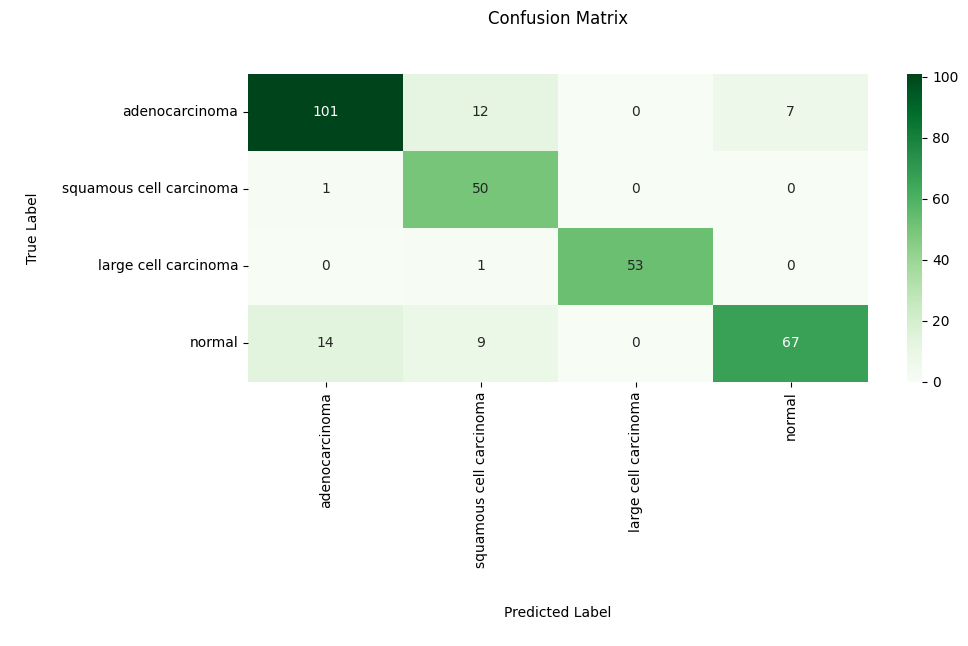

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
test_c = test_generator.class_indices

test_c = class_labels





cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

